# Libraries

In [3]:
%pip install requests


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
import sys
!{sys.executable} -m pip install scikit-learn scipy shap


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [ ]:
import numpy as np
import pandas as pd


from sklearn.preprocessing import KBinsDiscretizer
import shap
from sklearn.ensemble import RandomForestClassifier

#------------------------------------Plots
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff
import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import textwrap

from collections import Counter
import re
from scipy.stats import chi2_contingency, ks_2samp
import requests

#------------------------------------Plots Functions
import eda_utils
import importlib
importlib.reload(eda_utils)
from eda_utils import calculate_psi, plot_distribution_plotly, calculate_woe_iv
import utils_plot
from optbinning import BinningProcess
import joblib 
from sklearn.metrics import mutual_info_score
from joblib import Parallel, delayed

spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "false")
pd.set_option('display.max_columns', 500)


sns.set_style("whitegrid")
sns.set(rc = {'figure.figsize':(15,10)})



# Load data

In [6]:
df_model = pd.read_csv("df_model_to_fe.csv")

# Data Transformation

### Categorical features transformation

In [7]:
emp_length_mapping = {
    '10+ years': 10,
    '2 years': 2,
    '3 years': 3,
    '< 1 year': 0,
    '1 year': 1,
    '4 years': 4,
    '5 years': 5,
    '6 years': 6,
    '7 years': 7,
    '8 years': 8,
    '9 years': 9,
}
df_model['emp_length_numeric'] = df_model['emp_length'].map(emp_length_mapping)

#----------------------------------------------------------------------------------------------

df_model['term_numeric'] = df_model['term'].str.extract('(\d+)').astype(int)



#### Emp Title

In [9]:
print("Creating mapping function.")

def map_emp_title_v5_final(title):
    """
    Job Title Categorization. This version identifies niche roles, 
    common misspellings, and specific employers
    """
    
    if not isinstance(title, str) or title.strip() == '':
        return 'Other/Unknown'
    
    title_lower = title.lower().strip()


    # 1. Specific Info
    if 'kaiser permanente' in title_lower: return 'Healthcare (Kaiser)'
    if any(keyword in title_lower for keyword in ['bank of america', 'wells fargo', 'jp morgan', 'chase']): return 'Major Bank Employee'
    if 'walmart' in title_lower: return 'Major Retailer (Walmart)'
    if 'at&t' in title_lower: return 'Major Telecom (AT&T)'
    if 'department of defense' in title_lower: return 'Public Service (DoD)'
    if 'ibm' in title_lower: return 'IT & Engineering (IBM)'

    # 2. Healthcare
    if any(keyword in title_lower for keyword in ['nurse', 'rn', 'lpn', 'cna', 'physician', 'therapist', 'pharmacist', 'medical', 'dental', 'paramedic', 'healthcare', 'veterinarian', 'surgical', 'sonographer', 'caregiver', 'dentist', 'psychologist', 'emt', 'phlebotomist', 'lvn', 'radiologic technologist']):
        return 'Healthcare'

    # 3. Education
    if any(keyword in title_lower for keyword in ['teacher', 'professor', 'instructor', 'educator', 'principal', 'school', 'registrar', 'librarian', 'faculty', 'paraprofessional', 'superintendent']):
        return 'Education'
        
    # 4. IT & Engineering 
    if any(keyword in title_lower for keyword in ['engineer', 'developer', 'analyst', 'technician', ' it ', 'i.t.', 'software', 'network', 'systems', 'web', 'programmer', 'architect', 'tech', 'cpa']): # CPA es técnico-financiero, pero lo ponemos aquí
        return 'IT & Engineering'

    # 5. Finance & Accounting 
    if any(keyword in title_lower for keyword in ['accountant', 'accounting', 'financial', 'controller', 'bookkeeper', 'auditor', 'banker', 'underwriter', 'cfo', 'loan officer', 'finance', 'accounts', 'claims', 'adjuster', 'collector', 'trader', 'teller', 'broker', 'processor', 'billing']):
        return 'Finance & Accounting'

    # 6. Sales & Customer Service 
    if any(keyword in title_lower for keyword in ['sales', 'account executive', 'customer service', 'csr', 'agent', 'representative', 'concierge', 'service advisor', 'dealer', 'business development', 'merchandiser', 'associate']):
        if 'manager' not in title_lower:
            return 'Sales & Customer Service'

    # 7. Public Service 
    if any(keyword in title_lower for keyword in ['police', 'officer', 'firefighter', 'sheriff', 'sergeant', 'captain', 'army', 'military', 'deputy', 'government', 'navy', 'soldier', 'trooper', 'usaf', 'investigator', 'detective', 'security']):
        return 'Public Service'

    # 8. Postal Service
    if any(keyword in title_lower for keyword in ['postal', 'mail', 'usps', 'carrier']):
        return 'Postal Service'

    # 9. Logistics & Supply Chain
    if any(keyword in title_lower for keyword in ['logistics', 'supply chain', 'courier', 'ups', 'material handler', 'loader', 'warehouse']):
        return 'Logistics & Supply Chain'

    # 10. Transportation
    if any(keyword in title_lower for keyword in ['driver', 'pilot', 'dispatcher', 'truck', 'flight attendant', 'conductor']):
        return 'Transportation'

    # 11. Management / Executive
    if any(keyword in title_lower for keyword in ['manager', 'director', 'supervisor', 'president', 'owner', 'ceo', 'vice president', 'vp', 'partner', 'leader', 'chief', 'manger', 'management', 'gm', 'coo', 'cto', 'executive']):
        return 'Management/Executive'

    # 12. Skilled Trades & Labor
    if any(keyword in title_lower for keyword in ['mechanic', 'machinist', 'welder', 'foreman', 'forman', 'operator', 'maintenance', 'laborer', 'labor', 'pipefitter', 'painter', 'production', 'assembler', 'assembly', 'plumber', 'lineman']):
        return 'Skilled Trades & Labor'

    # 13. Administrative 
    if any(keyword in title_lower for keyword in ['assistant', 'clerk', 'secretary', 'receptionist', 'coordinator', 'administrator', 'admin', 'clerical', 'payroll', 'specialist']): # Specialist es genérico, lo ponemos aquí
        return 'Administrative'
        
    # 14. Food, Retail & Service
    if any(keyword in title_lower for keyword in ['server', 'bartender', 'cook', 'chef', 'cashier', 'hospitality', 'stocker', 'porter', 'baker', 'janitor', 'barista', 'hairstylist', 'stylist', 'waitress', 'waiter', 'housekeeper', 'housekeeping']):
        return 'Food, Retail & Service'

    # 15. Quality Assurance
    if any(keyword in title_lower for keyword in ['quality assurance', 'quality control']):
        return 'Quality Assurance'

    # 16. Procurement
    if any(keyword in title_lower for keyword in ['buyer', 'purchasing']):
        return 'Procurement'

    # 17. Human Resources 
    if any(keyword in title_lower for keyword in ['human resources', 'hr', 'recruiter', 'trainer']):
        return 'Human Resources'

    # 18. Art, Design & Media 
    if any(keyword in title_lower for keyword in ['artist', 'designer', 'graphic', 'writer', 'editor', 'producer']):
        return 'Art, Design & Media'
        
    # 19. Science & Research 
    if any(keyword in title_lower for keyword in ['scientist', 'research', 'chemist']):
        return 'Science & Research'

    
    if 'consultant' in title_lower: return 'Consulting'
    if any(keyword in title_lower for keyword in ['property', 'realtor']): return 'Real Estate'
    if any(keyword in title_lower for keyword in ['social worker', 'counselor', 'minister', 'pastor']): return 'Community & Social Services'
    if any(keyword in title_lower for keyword in ['construction', 'carpenter', 'electrician', 'installer', 'inspector', 'estimator']): return 'Construction & Installation'


    return 'Other/Unknown'



print("Applying the function to the 'emp_title' column...")
df_model['emp_title_final_grouped'] = df_model['emp_title'].apply(map_emp_title_v5_final)


print("\n--- Definitive Grouping Results (v5) for 'emp_title' ---")
print(f"Number of unique categories: {df_model['emp_title_final_grouped'].nunique()}")
print("\nFrequency of new categories (in %):")
print(df_model['emp_title_final_grouped'].value_counts(normalize=True).map('{:.2%}'.format))

Creating mapping function.
Applying the function to the 'emp_title' column...

--- Definitive Grouping Results (v5) for 'emp_title' ---
Number of unique categories: 29

Frequency of new categories (in %):
emp_title_final_grouped
Other/Unknown                  25.21%
Management/Executive           23.45%
IT & Engineering               10.28%
Healthcare                      7.10%
Sales & Customer Service        5.12%
Administrative                  5.12%
Education                       4.34%
Finance & Accounting            4.14%
Skilled Trades & Labor          3.58%
Public Service                  3.28%
Transportation                  2.50%
Food, Retail & Service          1.13%
Logistics & Supply Chain        0.76%
Consulting                      0.63%
Construction & Installation     0.59%
Community & Social Services     0.49%
Art, Design & Media             0.49%
Postal Service                  0.47%
Human Resources                 0.42%
Science & Research              0.21%
Major Bank 

### Saving Titles for Deep-Dive Analysis

In [10]:
all_titles_string = df_model[df_model['emp_title_final_grouped'] == 'Other/Unknown']['emp_title'].value_counts().to_string()


file_name = 'emp_titulos_clasificacion.txt' 

try:
    with open(file_name, 'w', encoding='utf-8') as f:
        f.write(all_titles_string)
    print(f"Titles have been successfully saved to '{file_name}'")
except Exception as e:
    print(f"An error occurred while saving the file: {e}")

Titles have been successfully saved to 'emp_titulos_clasificacion.txt'


#### Loan Purpose

In [11]:
def map_loan_title(title):
    """
    Categorize loan titles through a thorough keyword analysis. 
    This is our most complete version, encompassing niche categories.
    """
    if not isinstance(title, str):
        return 'Other'
    
    title_lower = title.lower().strip()



    # 1.  Credit Refinancing
    if 'credit' in title_lower and 'card' in title_lower:
        return 'Credit Card Refinancing'
    if 'refi' in title_lower or 'refinance' in title_lower or 'payoff' in title_lower or 'consolidation' in title_lower or 'consolidate' in title_lower or 'cosolidation ' in title_lower:
        return 'Credit Card Refinancing'

    # 2. Debt Consolidation
    if 'consolidation' in title_lower or 'payoff' in title_lower or 'pay off' in title_lower or 'bills' in title_lower or 'consolidate' in title_lower or 'consol' in title_lower or 'cons' in title_lower or 'debt' in title_lower:
        return 'Debt Consolidation'

    # 3. Home Improvement
    if 'home' in title_lower or 'house' in title_lower or 'kitchen' in title_lower or 'remodel' in title_lower or 'improvement' in title_lower or 'pool' in title_lower or 'roof' in title_lower or 'repairs' in title_lower or 'renovation' in title_lower:
        return 'Home Improvement'

    # 4. Home Buying
    if 'home' in title_lower and 'buy' in title_lower:
        return 'Home Buying'
    if 'down payment' in title_lower:
        return 'Home Buying'

    # 5. Car Financing
    if 'car' in title_lower or 'auto' in title_lower or 'vehicle' in title_lower or 'motorcycle' in title_lower or 'harley' in title_lower:
        return 'Car Financing'
        
    # 6. Major Purchase
    if 'major purchase' in title_lower:
        return 'Major Purchase'

    # 7. Medical Expenses
    if 'medical' in title_lower or 'health' in title_lower or 'dental' in title_lower:
        return 'Medical Expenses'

    # 8. Business Loan
    if 'business' in title_lower:
        return 'Business Loan'

    # 9. Moving and Relocation
    if 'moving' in title_lower or 'relocation' in title_lower:
        return 'Moving and Relocation'

    # 10. Vacation
    if 'vacation' in title_lower or 'trip' in title_lower:
        return 'Vacation'
        
    # 11. Wedding
    if 'wedding' in title_lower or 'engagement' in title_lower:
        return 'Wedding'
        
    # 12. Education
    if 'education' in title_lower or 'school' in title_lower or 'student' in title_lower:
        return 'Education'
        
    # 13. Taxes
    if 'tax' in title_lower or 'taxes' in title_lower:
        return 'Taxes'

    # 14. Green Loan 
    if 'green loan' in title_lower:
        return 'Green Loan'

    if 'personal'  in title_lower or 'my loan' in title_lower or 'mine' in title_lower or 'free' in title_lower :
        return 'Personal Loan'


    return 'Other'


print("Applying thefunction to the 'title' column.")
df_model['title_grouped'] = df_model['title'].apply(map_loan_title)


print("\n--- Final Grouping Results for 'title' ---")
print(f"Number of unique categories: {df_model['title_grouped'].nunique()}")
print("\nFrequency of new categories:")
print(df_model['title_grouped'].value_counts())

Applying thefunction to the 'title' column.

--- Final Grouping Results for 'title' ---
Number of unique categories: 16

Frequency of new categories:
title_grouped
Credit Card Refinancing    1002581
Other                       127013
Home Improvement             92575
Major Purchase               24644
Debt Consolidation           23958
Car Financing                15376
Medical Expenses             14917
Business Loan                14018
Personal Loan                10786
Moving and Relocation         9170
Vacation                      8736
Wedding                       2513
Green Loan                     746
Education                      508
Taxes                          417
Home Buying                    101
Name: count, dtype: int64


#### ZIP Code Enrich Information

In [12]:
print("Fetching Median Household Income data from the U.S. Census API...")
API_URL = "https://api.census.gov/data/2023/acs/acs5/profile?get=NAME,DP03_0062E&for=zip%20code%20tabulation%20area:*"
response = requests.get(API_URL)

if response.status_code == 200:
    print("Successfully connected to the Census API!")
    data = response.json()
    df_census = pd.DataFrame(data[1:], columns=data[0])
else:
    print(f"Error contacting the Census API. Status code: {response.status_code}")
    df_census = pd.DataFrame()

if not df_census.empty:

    print("\nCleaning and preparing census data...")
    df_census = df_census.rename(columns={
        "DP03_0062E": "median_household_income",
        "zip code tabulation area": "zip_code_5_digit"
    })
    df_census['median_household_income'] = pd.to_numeric(df_census['median_household_income'], errors='coerce')
    df_census.dropna(subset=['median_household_income'], inplace=True)
    df_census['zip_code_5_digit'] = df_census['zip_code_5_digit'].astype(str)

   
    print("\nAdding 3-digit level census data to match our data...")


    df_census['zip_code_3_digit'] = df_census['zip_code_5_digit'].str[:3]

    df_census_agg = df_census.groupby('zip_code_3_digit')['median_household_income'].median().reset_index()
    df_census_agg = df_census_agg.rename(columns={'median_household_income': 'region_median_income'})

    print(f"Aggregated incomes calculated for {len(df_census_agg)} 3-digit regions.")
    print("Example of aggregated census data:")
    print(df_census_agg.head())

    
    print("\nPreparing the main DataFrame for merging...")
    
  
    df_model['zip_code_3_digit'] = df_model['zip_code'].str[:3]
    
    print("Performing the merge with the aggregated data...")
    

    df_model = pd.merge(
        df_model,
        df_census_agg,
        on='zip_code_3_digit',
        how='left' 
    )
    

    print("\nMerge complete! The new 'region_median_income' feature has been added.")

    null_count = df_model['region_median_income'].isnull().sum()
    total_rows = len(df_model)
    print(f"Were found {null_count} loans ({null_count/total_rows:.2%}) without a corresponding income data.")
    
    if null_count > 0:
        median_overall = df_model['region_median_income'].median()
        df_model['region_median_income'].fillna(median_overall, inplace=True)
        print(f"Null values have been filled with the overall median regional income: ${median_overall:,.0f}")

    print("\nDescription of the new variable:")
    print(df_model['region_median_income'].describe().apply("{:,.0f}".format))
    
    print("\nPreview of the final DataFrame:")
 
    df_model.drop(columns=['zip_code_3_digit'], inplace=True, errors='ignore')
    print(df_model[['zip_code', 'region_median_income', 'target']].head())


Fetching Median Household Income data from the U.S. Census API...
Successfully connected to the Census API!

Cleaning and preparing census data...

Adding 3-digit level census data to match our data...
Aggregated incomes calculated for 894 3-digit regions.
Example of aggregated census data:
  zip_code_3_digit  region_median_income
0              006               20984.5
1              007               22578.0
2              009               29540.5
3              010               88223.0
4              011               51851.0

Preparing the main DataFrame for merging...
Performing the merge with the aggregated data...

Merge complete! The new 'region_median_income' feature has been added.
Were found 377 loans (0.03%) without a corresponding income data.
Null values have been filled with the overall median regional income: $77,297

Description of the new variable:
count       1,348,059
mean         -271,154
std        15,042,138
min      -666,666,666
25%            64,288
50%     

/var/folders/v4/7dg4p38j5c31bxdhb2vhmmb00000gp/T/ipykernel_13116/110207441.py:62: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





  zip_code  region_median_income  target
0    190xx              108393.5     0.0
1    577xx               58810.0     0.0
2    605xx              109230.0     0.0
3    174xx               77134.0     0.0
4    300xx               85558.5     0.0


### Finalcial Ratios

In [13]:
def create_financial_ratios(df):
    """
    Create a set of interaction features and financial ratios based on pre-decision data.
    This function avoids data leakage by using 'loan_amnt' instead of 'funded_amnt'.
    It handles division by zero by replacing the resulting infinities with a safe value (e.g., 0 or NaN).
    """
    print("Creating new financial ratio features...")
    
    # A small epsilon to prevent division by zero in a robust way
    epsilon = 1e-6

    # --- Loan and Debt Burden Ratios (relative to income) ---
    
    # Loan-to-Annual Income Ratio (Using 'loan_amnt' to avoid data leakage)
    # This ratio indicates how large the requested loan is compared to the applicant's annual income.
    df['loan_to_income_ratio'] = df['funded_amnt'] / (df['annual_inc'] + epsilon)
    
    # Revolving Debt Balance to Annual Income Ratio
    # This shows the burden of existing revolving debt relative to income.
    df['revolving_balance_to_income_ratio'] = df['revol_bal'] / (df['annual_inc'] + epsilon)

    # --- Credit Behavior and Usage Ratios ---

    # Manual Revolving Credit Utilization Ratio
    # Measures how much of the available revolving credit is being used.
    df['credit_utilization_manual'] = df['revol_bal'] / (df['revol_bal'] + df['bc_open_to_buy'] + epsilon)
    
    # Open Accounts to Total Accounts Ratio
    # Represents the proportion of credit lines that are currently open.
    df['open_acc_ratio'] = df['open_acc'] / (df['total_acc'] + epsilon)
    
    # --- Credit History and Loan Term Ratios ---

 
    # --- Income Context Ratio ---
    
    # Applicant's Income relative to their Region's Median Income
    # This contextualizes income based on local cost of living.
    df['income_to_region_median_ratio'] = df['annual_inc'] / (df['region_median_income'] + epsilon)
    
    # --- Post-processing: Handle potential NaNs or infinities from division ---
    ratio_cols = [
        'loan_to_income_ratio', 'revolving_balance_to_income_ratio', 
        'credit_utilization_manual', 'open_acc_ratio', 
        'income_to_region_median_ratio'
    ]
    
    # Replace any infinite values that might have occurred with NaN
    df[ratio_cols] = df[ratio_cols].replace([np.inf, -np.inf], np.nan)
    # Fill any resulting NaNs (e.g., from 0/0 division) with 0
    df[ratio_cols] = df[ratio_cols].fillna(0)
        
    print("New features created successfully!")
    return df

# Apply the function to our dataframe
df_model = create_financial_ratios(df_model)

# Display the new columns along with some of the original ones for verification
new_feature_columns = [
     'funded_amnt', 'annual_inc', 'loan_to_income_ratio',
     'revol_bal', 'revolving_balance_to_income_ratio',
     'bc_open_to_buy', 'credit_utilization_manual',
     'open_acc', 'total_acc', 'open_acc_ratio',
     'term_numeric', 'credit_history_length_months', 
     'region_median_income', 'income_to_region_median_ratio'
 ]

print("\nPreview of the new features:")
display(df_model[new_feature_columns].head())

Creating new financial ratio features...
New features created successfully!

Preview of the new features:


,funded_amnt,annual_inc,loan_to_income_ratio,revol_bal,revolving_balance_to_income_ratio,bc_open_to_buy,credit_utilization_manual,open_acc,total_acc,open_acc_ratio,term_numeric,credit_history_length_months,region_median_income,income_to_region_median_ratio
0,3600.0,55000.0,0.065455,2765.0,0.050273,1506.0,0.647389,7.0,13.0,0.538461,36,148.00,108393.5,0.507410
1,24700.0,65000.0,0.380000,21470.0,0.330308,57830.0,0.270744,22.0,38.0,0.578947,36,191.98,58810.0,1.105254
2,20000.0,63000.0,0.317460,7869.0,0.124905,2737.0,0.741939,6.0,18.0,0.333333,60,183.97,109230.0,0.576765
3,10400.0,104433.0,0.099585,21929.0,0.209982,4567.0,0.827634,12.0,35.0,0.342857,60,209.99,77134.0,1.353917
4,11950.0,34000.0,0.351471,8822.0,0.259471,844.0,0.912684,5.0,6.0,0.833333,36,337.98,85558.5,0.397389


In [ ]:
def select_features_by_correlation_iv(df, target_col, corr_threshold=0.7):
    """
    Selects features by removing one from each highly correlated pair,
    based on which one has the lower Information Value (IV).

    Args:
        df (pd.DataFrame): The DataFrame containing features and the target.
        target_col (str): The name of the target column.
        corr_threshold (float): The correlation threshold (absolute value) to consider a pair.

    Returns:
        list: A list of recommended column names to remove.
    """
    print(f"Initiating feature selection with correlation threshold > {corr_threshold}\n")
    
    df_numeric = df.select_dtypes(include=np.number)
    corr_matrix = df_numeric.corr().abs()
    
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    highly_correlated_pairs = upper_triangle.stack().reset_index()
    highly_correlated_pairs.columns = ['Variable_1', 'Variable_2', 'Correlation']
    highly_correlated_pairs = highly_correlated_pairs[highly_correlated_pairs['Correlation'] > corr_threshold]
    
    vars_to_drop = set()
    
    print("--- Comparing Highly Correlated Pairs ---")
    
    for index, row in highly_correlated_pairs.iterrows():
        col1 = row['Variable_1']
        col2 = row['Variable_2']
        
        if col1 in vars_to_drop or col2 in vars_to_drop:
            continue
            
        _, iv1 = calculate_woe_iv(df, col1, target_col)
        _, iv2 = calculate_woe_iv(df, col2, target_col)
        
        print(f"- Pair: ('{col1}' vs '{col2}'). Correlation: {row['Correlation']:.2f}")
        print(f"  - IV of '{col1}': {iv1:.4f}")
        print(f"  - IV of '{col2}': {iv2:.4f}")
        
        if iv1 >= iv2:
            drop_candidate = col2
            keep_candidate = col1
            print(f"  ==> Decision: Keep '{keep_candidate}', remove '{drop_candidate}'.\n")
            vars_to_drop.add(drop_candidate)
        else:
            drop_candidate = col1
            keep_candidate = col2
            print(f"  ==> Decision: Keep '{keep_candidate}', remove '{drop_candidate}'.\n")
            vars_to_drop.add(drop_candidate)
            
    print("--- Final Selection Process Completed ---")
    if not vars_to_drop:
        print("No variables were found to remove with the current threshold.")
    
    return list(vars_to_drop)


variables_to_drop = select_features_by_correlation_iv(df_model, 'target', corr_threshold=0.7)

print("\nFINAL LIST OF RECOMMENDED VARIABLES TO REMOVE:")
print(variables_to_drop)


if variables_to_drop:
    df_model_final = df_model.drop(columns=variables_to_drop)
    print(f"\n'df_model_final' has been created with {df_model_final.shape[1]} columns (before: {df_model.shape[1]}).")
    print("This is the DataFrame you should use to train your model.")

else:
    df_model_final = df_model.copy()
    print("\nNo variables were removed. 'df_model_final' is a copy of the original dataframe.")


In [15]:
deleted_vars = ['income_to_region_median_ratio', 'credit_history_length_months', 'percent_bc_gt_75', 'total_acc']

Removing non-important features 

In [16]:
df_model_final =  df_model_final.drop(['term', 'emp_title', 'emp_length', 'purpose', 'title' ], axis=1)

### Measuring Correlation for categorical features

Found 11 categorical columns to analyze.
Original dataset has 1348059 rows. Using a sample of 50000 to speed up.

Calculating mutual information for 66 pairs using parallel processing...
Calculation complete. Building the results matrix...

--- Top 20 Categorical Variable Pairs by Mutual Information ---
addr_state               zip_code                   3.331780
sub_grade                grade                      1.613384
d_vintage                zip_code                   0.615207
Set                      d_vintage                  0.573036
zip_code                 sub_grade                  0.247826
emp_title_final_grouped  zip_code                   0.172207
                         d_vintage                  0.141423
d_vintage                initial_list_status        0.120240
title_grouped            d_vintage                  0.098664
                         zip_code                   0.083678
zip_code                 home_ownership             0.079015
d_vintage               

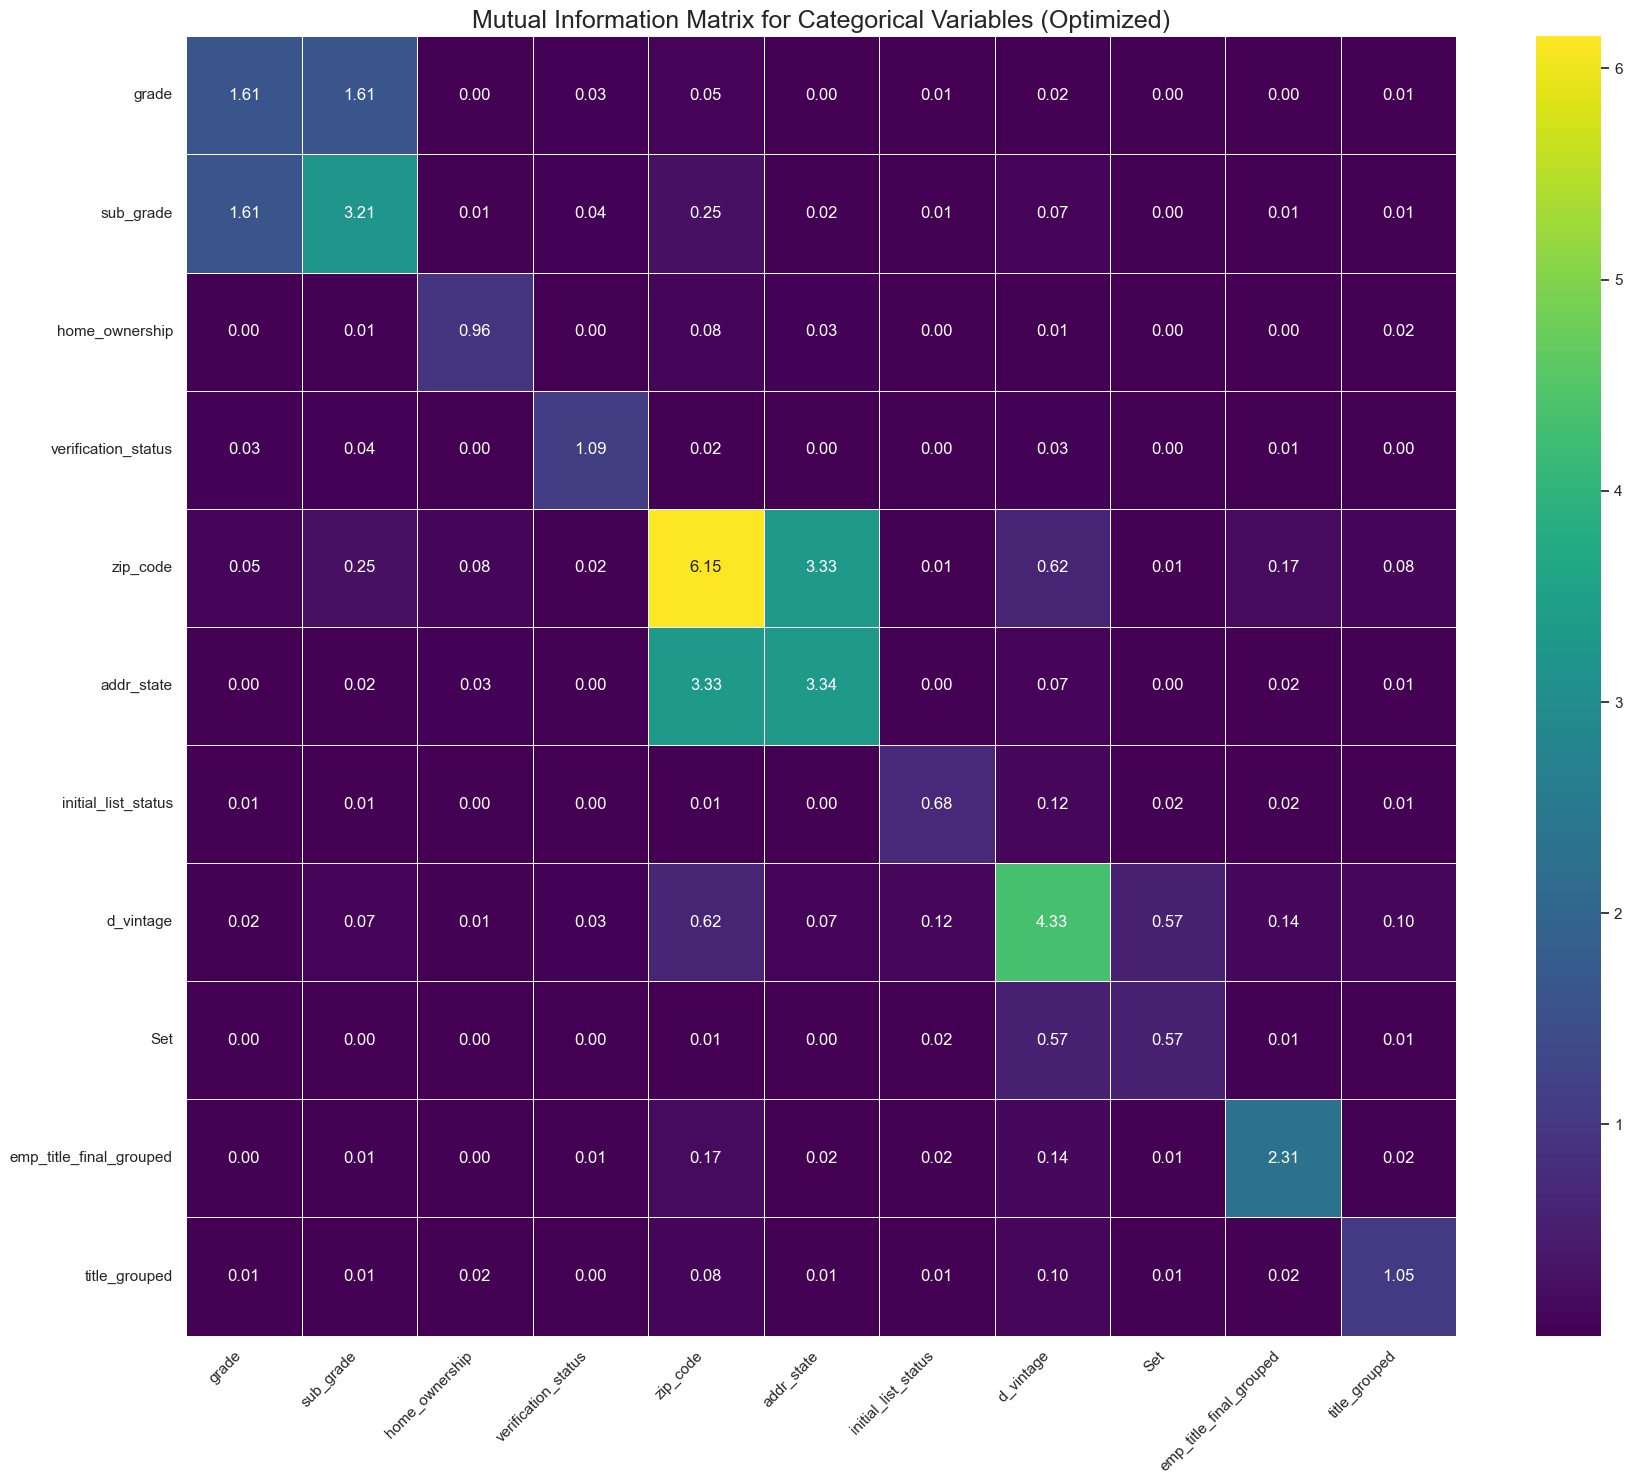

In [17]:

df = df_model_final.copy()

SAMPLE_SIZE = 50000  
N_JOBS = -1         




categorical_cols = df.select_dtypes(include=['object', 'category']).columns
df_categorical = df[categorical_cols]
print(f"Found {len(categorical_cols)} categorical columns to analyze.")


if len(df_categorical) > SAMPLE_SIZE:
    df_sample = df_categorical.sample(n=SAMPLE_SIZE, random_state=42)
    print(f"Original dataset has {len(df_categorical)} rows. Using a sample of {SAMPLE_SIZE} to speed up.")
else:
    df_sample = df_categorical
    print("Dataset is smaller than sample size. Using the full dataset.")


all_cols = list(df_sample.columns)
pairs = []
for i in range(len(all_cols)):
    for j in range(i, len(all_cols)):
        pairs.append((all_cols[i], all_cols[j]))


def calculate_mi(col1, col2, df):
    return mutual_info_score(df[col1], df[col2])

print(f"\nCalculating mutual information for {len(pairs)} pairs using parallel processing...")


mi_scores = Parallel(n_jobs=N_JOBS)(delayed(calculate_mi)(p[0], p[1], df_sample) for p in pairs)

print("Calculation complete. Building the results matrix...")


mi_matrix = pd.DataFrame(np.zeros((len(all_cols), len(all_cols))),
                         index=all_cols,
                         columns=all_cols)

for k, (col1, col2) in enumerate(pairs):
    score = mi_scores[k]
    mi_matrix.loc[col1, col2] = score
    mi_matrix.loc[col2, col1] = score


upper_tri = mi_matrix.where(np.triu(np.ones(mi_matrix.shape), k=1).astype(bool))
top_pairs = upper_tri.unstack().dropna().sort_values(ascending=False)

print("\n--- Top 20 Categorical Variable Pairs by Mutual Information ---")
print(top_pairs.head(20))

# Visualizar la matriz completa
plt.figure(figsize=(18, 15))
sns.heatmap(mi_matrix, cmap='viridis', annot=True, fmt='.2f', linewidths=.5)
plt.title('Mutual Information Matrix for Categorical Variables (Optimized)', fontsize=18)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

#### Last Pruning Before WoE

In [18]:
df_model_final = df_model_final.drop(['grade', 'zip_code', 'inq_last_6mths', 'open_acc', 'revol_bal', 'mths_since_last_delinq',
'delinq_2yrs','pub_rec', 'initial_list_status' ], axis=1)

# WoE Transformation


In [ ]:
df_train = df_model_final[df_model_final['Set']=='Train'].drop([ 'Set', 'target'], axis=1).set_index(['id', 'd_vintage'])
y_train =  df_model_final[df_model_final['Set']=='Train'].set_index(['id', 'd_vintage'])['target']

df_test = df_model_final[df_model_final['Set']=='Test'].drop(['Set', 'target'], axis=1).set_index(['id', 'd_vintage'])
y_test = df_model_final[df_model_final['Set']=='Test'].set_index(['id', 'd_vintage'])['target']


#----------------------------------------------------------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------------------------------------


variable_names = df_train.columns.tolist()


categorical_variables = ['emp_title_final_grouped', 'title_grouped', 'zip_code', 'verification_status' ,'home_ownership',	'sub_grade']

binning_process = BinningProcess(variable_names, categorical_variables=categorical_variables,)



binning_process.fit(df_train, y_train)                          

### Tranformation 

In [20]:
df_test_woe = binning_process.transform(df_test, metric="woe")
df_test_woe['set'] = 'test'

df_train_woe = binning_process.transform(df_train, metric="woe")
df_train_woe['set'] = 'train'

df_total_woe = pd.concat([df_train_woe, df_test_woe], axis=0).reset_index()
 
y_woe = pd.concat([ y_train, y_test], axis=0).reset_index()

df_total_woe = df_total_woe.merge(y_woe, on=['id', 'd_vintage'], how='inner').drop_duplicates(['id'])


print("\n--- Resumen del Proceso de Binning (IV por variable) ---")
binning_summary = binning_process.summary()
display(binning_summary)


#file_path = "binning_process_final.joblib"
#joblib.dump(binning_process, file_path)
#print(f"\nThe binning process has been saved to: '{file_path}'")


--- Resumen del Proceso de Binning (IV por variable) ---


,name,dtype,status,selected,n_bins,iv,js,gini,quality_score
0,funded_amnt,numerical,OPTIMAL,True,8,0.033396,0.004164,0.100453,0.113415
1,int_rate,numerical,OPTIMAL,True,14,0.475926,0.056266,0.371648,0.943104
2,sub_grade,categorical,OPTIMAL,True,16,0.508089,0.060026,0.385198,0.918259
3,home_ownership,categorical,OPTIMAL,True,3,0.02428,0.003032,0.081158,0.073545
4,annual_inc,numerical,OPTIMAL,True,12,0.032048,0.003994,0.099677,0.103954
5,verification_status,categorical,OPTIMAL,True,3,0.050637,0.006302,0.112137,0.173411
6,addr_state,categorical,OPTIMAL,True,11,0.013917,0.001736,0.064126,0.013049
7,dti,numerical,OPTIMAL,True,15,0.079229,0.00983,0.158945,0.19244
8,fico_range_high,numerical,OPTIMAL,True,13,0.125498,0.015346,0.185027,0.486632
9,all_util,numerical,OPTIMAL,True,3,0.017352,0.002158,0.047429,0.030345


In [21]:
df_total_woe

,id,d_vintage,funded_amnt,int_rate,sub_grade,home_ownership,annual_inc,verification_status,addr_state,dti,fico_range_high,all_util,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_actv_rev_tl,emp_length_numeric,term_numeric,emp_title_final_grouped,title_grouped,region_median_income,loan_to_income_ratio,revolving_balance_to_income_ratio,credit_utilization_manual,open_acc_ratio,set,target
0,68407277,2015-12-01,0.258841,-0.104389,-0.287373,0.160306,-0.086534,0.365801,-0.067006,0.403308,-0.217115,0.106942,-0.405376,0.024740,0.156173,-0.155903,-0.077618,-0.148191,-0.172215,-0.034501,-0.169441,-0.089716,0.084253,0.057010,0.310279,-0.020484,-0.007931,0.099562,0.457006,0.063355,0.023397,-0.007500,train,0.0
1,68355089,2015-12-01,-0.152670,0.229718,0.088483,0.160306,-0.030447,0.365801,-0.101768,0.107425,0.280817,0.106942,-0.405376,0.024740,-0.056093,0.630465,0.061496,-0.179923,-0.205649,0.238651,-0.252891,-0.260049,0.020176,0.057010,0.310279,0.172054,-0.081017,-0.075997,-0.478301,-0.066297,0.283653,-0.079388,train,0.0
2,68341763,2015-12-01,-0.152670,0.440679,0.355937,0.160306,-0.030447,0.365801,0.120678,0.282040,0.021937,-0.231529,-0.044784,-0.181297,0.378525,-0.139264,0.037777,0.025413,0.188066,0.238651,0.391569,0.047732,0.161126,0.057010,-0.721577,-0.313243,-0.081017,0.099562,-0.326559,0.111091,-0.045164,0.112083,train,0.0
3,68476807,2015-12-01,-0.052293,-1.109875,-1.167190,0.160306,0.262201,-0.078360,-0.067006,-0.164547,0.021937,-0.398292,-0.405376,-0.578527,0.378525,-0.075754,0.061496,-0.111674,-0.098426,0.350769,-0.169441,-0.260049,-0.044349,0.010116,-0.721577,-0.020484,-0.007931,-0.035045,0.387752,0.023428,-0.098688,0.112083,train,0.0
4,68426831,2015-12-01,-0.052293,-0.104389,-0.155127,-0.168686,-0.212208,-0.078360,0.094121,0.282040,-0.044342,-0.398292,-0.044784,0.456646,-0.176827,-0.194252,-0.392487,0.400004,0.495469,-0.189779,0.152740,0.000000,0.161126,0.010116,0.310279,-0.020484,-0.007931,0.054853,-0.478301,-0.032938,-0.127045,-0.226646,train,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1348054,145419806,2018-12-01,0.206653,-0.247124,-0.039680,0.160306,0.072425,0.365801,0.023641,0.403308,-0.264035,0.106942,-0.405376,-0.079886,-0.176827,-0.010297,-0.137330,-0.148191,-0.172215,-0.189779,0.391569,-0.141744,0.237851,0.010116,0.310279,0.012941,-0.007931,0.054853,0.387752,0.043867,0.290291,-0.181678,test,0.0
1348055,145499677,2018-12-01,0.107043,0.948821,1.287666,0.160306,0.169827,-0.078360,0.255807,0.107425,0.280817,-0.231529,-0.044784,-0.181297,0.156173,0.332711,-0.137330,-0.111674,-0.098426,-0.034501,-0.127529,-0.089716,0.084253,0.010116,0.310279,-0.086344,-0.007931,-0.173368,0.387752,0.078482,0.283653,0.112083,test,0.0
1348056,145056086,2018-12-01,-0.240557,0.948821,1.287666,-0.035376,-0.155503,-0.078360,-0.014735,0.425187,1.098914,0.106942,-0.044784,0.300659,-0.176827,0.184215,-0.003699,0.001416,0.188066,0.238651,0.391569,0.231346,0.237851,0.000000,0.310279,-0.020484,-0.007931,0.054853,-0.565804,0.043867,0.290291,0.179891,test,0.0
1348057,145509696,2018-12-01,-0.152670,-0.104389,0.088483,0.160306,0.032255,0.365801,-0.086921,-0.534175,-0.382170,-0.398292,-0.405376,-0.380298,0.263099,0.040141,-0.392487,-0.066827,-0.205649,0.079431,-0.127529,-0.162778,-0.087466,0.010116,0.310279,-0.086344,-0.007931,-0.035598,0.054483,0.078482,0.122036,-0.181678,test,0.0


In [22]:
print('Dimension of final data', df_total_woe.shape)

df_total_woe.head(3)

Dimension of final data (1348059, 34)


,id,d_vintage,funded_amnt,int_rate,sub_grade,home_ownership,annual_inc,verification_status,addr_state,dti,fico_range_high,all_util,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_actv_rev_tl,emp_length_numeric,term_numeric,emp_title_final_grouped,title_grouped,region_median_income,loan_to_income_ratio,revolving_balance_to_income_ratio,credit_utilization_manual,open_acc_ratio,set,target
0,68407277,2015-12-01,0.258841,-0.104389,-0.287373,0.160306,-0.086534,0.365801,-0.067006,0.403308,-0.217115,0.106942,-0.405376,0.024740,0.156173,-0.155903,-0.077618,-0.148191,-0.172215,-0.034501,-0.169441,-0.089716,0.084253,0.05701,0.310279,-0.020484,-0.007931,0.099562,0.457006,0.063355,0.023397,-0.007500,train,0.0
1,68355089,2015-12-01,-0.152670,0.229718,0.088483,0.160306,-0.030447,0.365801,-0.101768,0.107425,0.280817,0.106942,-0.405376,0.024740,-0.056093,0.630465,0.061496,-0.179923,-0.205649,0.238651,-0.252891,-0.260049,0.020176,0.05701,0.310279,0.172054,-0.081017,-0.075997,-0.478301,-0.066297,0.283653,-0.079388,train,0.0
2,68341763,2015-12-01,-0.152670,0.440679,0.355937,0.160306,-0.030447,0.365801,0.120678,0.282040,0.021937,-0.231529,-0.044784,-0.181297,0.378525,-0.139264,0.037777,0.025413,0.188066,0.238651,0.391569,0.047732,0.161126,0.05701,-0.721577,-0.313243,-0.081017,0.099562,-0.326559,0.111091,-0.045164,0.112083,train,0.0


### Binining feature exploration

In [ ]:

all_binning_tables = []


for variable in binning_process.variable_names:
   
    binning_table = binning_process.get_binned_variable(variable).binning_table.build()
    
  
    binning_table['Variable'] = variable
    

    all_binning_tables.append(binning_table)


combined_binning_df = pd.concat(all_binning_tables, ignore_index=True)


first_cols = ['Variable', 'Bin']
other_cols = [col for col in combined_binning_df.columns if col not in first_cols]
combined_binning_df = combined_binning_df[first_cols + other_cols]


In [24]:
combined_binning_df.Variable.unique()

array(['funded_amnt', 'int_rate', 'sub_grade', 'home_ownership',
       'annual_inc', 'verification_status', 'addr_state', 'dti',
       'fico_range_high', 'all_util', 'inq_last_12m',
       'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy',
       'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
       'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq',
       'num_actv_rev_tl', 'emp_length_numeric', 'term_numeric',
       'emp_title_final_grouped', 'title_grouped', 'region_median_income',
       'loan_to_income_ratio', 'revolving_balance_to_income_ratio',
       'credit_utilization_manual', 'open_acc_ratio'], dtype=object)

In [26]:
combined_binning_df.to_csv('df_binning_woe_all_variables.csv', index=False)

In [203]:
combined_binning_df[combined_binning_df['Variable']=='revolving_balance_to_income_ratio']

,Variable,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
321,revolving_balance_to_income_ratio,"(-inf, 0.04)",60995,0.060738,49753,11242,0.184310,0.043867,1.152984e-04,1.441114e-05
322,revolving_balance_to_income_ratio,"[0.04, 0.07)",73187,0.072879,59911,13276,0.181398,0.063355,2.868169e-04,3.584611e-05
323,revolving_balance_to_income_ratio,"[0.07, 0.11)",143763,0.143157,118006,25757,0.179163,0.078482,8.604614e-04,1.075301e-04
324,revolving_balance_to_income_ratio,"[0.11, 0.13)",50855,0.050641,41985,8870,0.174417,0.111091,6.036234e-04,7.541416e-05
325,revolving_balance_to_income_ratio,"[0.13, 0.18)",146347,0.145730,119726,26621,0.181903,0.059959,5.142237e-04,6.426834e-05
326,revolving_balance_to_income_ratio,"[0.18, 0.22)",97117,0.096708,78917,18200,0.187403,0.023428,5.269727e-05,6.587008e-06
327,revolving_balance_to_income_ratio,"[0.22, 0.25)",78407,0.078077,63473,14934,0.190468,0.003427,9.161427e-07,1.145178e-07
328,revolving_balance_to_income_ratio,"[0.25, 0.30)",99226,0.098808,79764,19462,0.196138,-0.032938,1.082929e-04,1.353600e-05
329,revolving_balance_to_income_ratio,"[0.30, 0.34)",53894,0.053667,43037,10857,0.201451,-0.066297,2.407224e-04,3.008479e-05
330,revolving_balance_to_income_ratio,"[0.34, 0.40)",59202,0.058953,46825,12377,0.209064,-0.112969,7.787136e-04,9.728747e-05


#### Risk Analysis & WoE

/var/folders/v4/7dg4p38j5c31bxdhb2vhmmb00000gp/T/ipykernel_52231/3766240891.py:41: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/v4/7dg4p38j5c31bxdhb2vhmmb00000gp/T/ipykernel_52231/3766240891.py:41: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/v4/7dg4p38j5c31bxdhb2vhmmb00000gp/T/ipykernel_52231/3766240891.py:41: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/v4/7dg4p38j5c31bxdhb2vhmmb00000gp/T/ipykernel_52231/3766240891.py:41: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



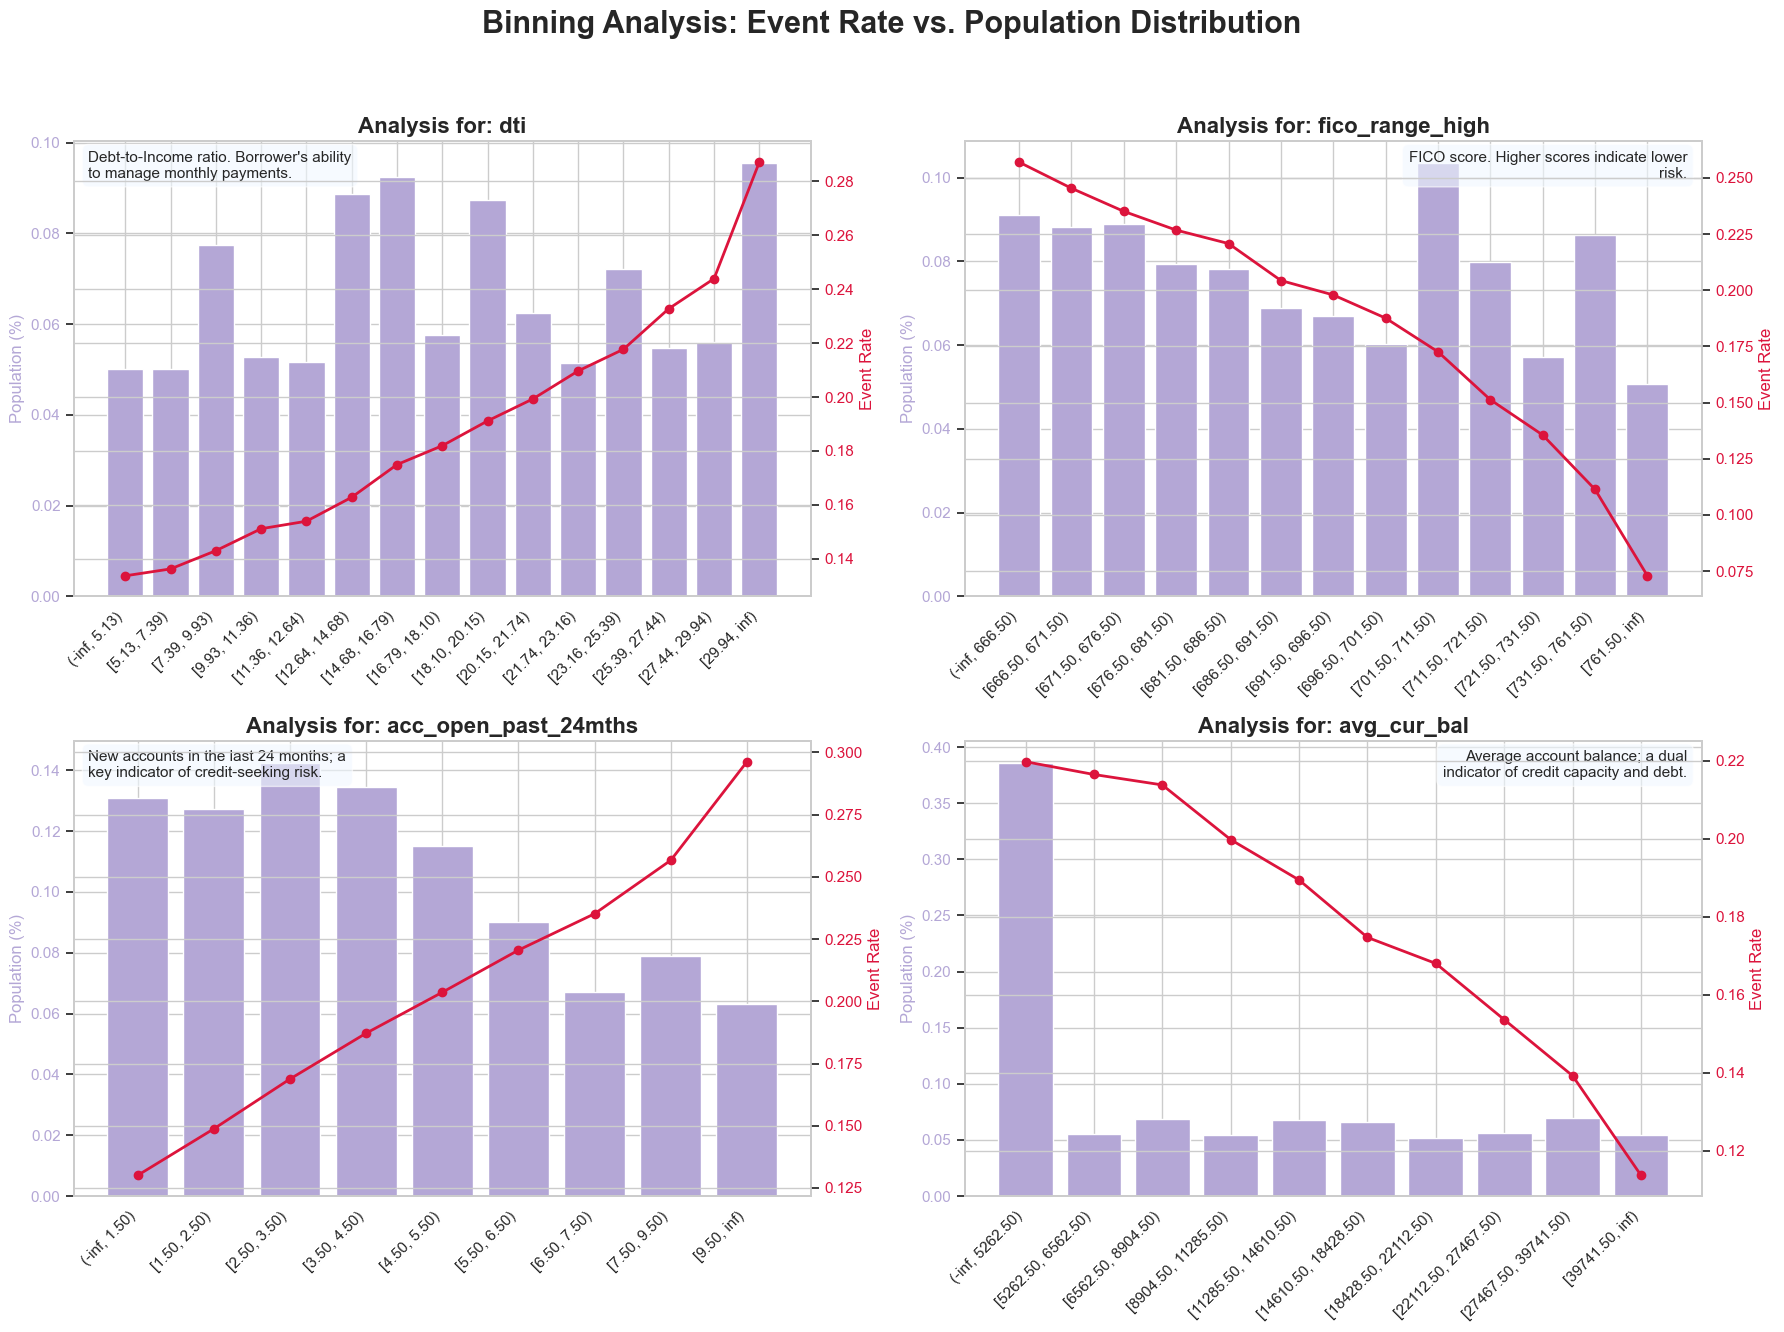

In [121]:
variables_to_plot = [ 'dti', 'fico_range_high', 'acc_open_past_24mths', 'avg_cur_bal']

variable_descriptions = {
    
    'dti': "Debt-to-Income ratio. Borrower's ability to manage monthly payments.",
    'fico_range_high': "FICO score. Higher scores indicate lower risk.",
    'acc_open_past_24mths': 'New accounts in the last 24 months; a key indicator of credit-seeking risk.',
    'avg_cur_bal': 'Average account balance; a dual indicator of credit capacity and debt.'}


sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (18, 14)


fig, axes = plt.subplots(2, 2)
axes = axes.flatten()

for i, var_name in enumerate(variables_to_plot):
    ax = axes[i]
    
    df_var = combined_binning_df[combined_binning_df['Variable'] == var_name].copy()
    df_plot = df_var[~df_var['Bin'].isin(['', 'Missing', 'Special'])].copy()
    df_plot['Bin'] = df_plot['Bin'].astype(str)

    
    color_bar =   '#b4a7d6' 
    ax.set_ylabel('Population (%)', color=color_bar, fontsize=12)
    ax.bar(df_plot['Bin'], df_plot['Count (%)'], color=color_bar, label='Population (%)')
    ax.tick_params(axis='y', labelcolor=color_bar)
    ax.set_title(f'Analysis for: {var_name}', fontsize=16, weight='bold')


    ax2 = ax.twinx()
    color_line = 'crimson'

    ax2.set_ylabel('Event Rate', color=color_line, fontsize=12)

    ax2.plot(df_plot['Bin'], df_plot['Event rate'], color=color_line, marker='o', linewidth=2, label='Event Rate')
    ax2.tick_params(axis='y', labelcolor=color_line)
    
    ax.set_xticklabels(df_plot['Bin'], rotation=45, ha='right')
    

    description = variable_descriptions.get(var_name, '')
    wrapped_desc = textwrap.fill(description, width=40)
    
    x_pos = 0.02
    ha = 'left'
    
    if var_name in ['fico_range_high','avg_cur_bal']:
        x_pos = 0.98
        ha = 'right'
        
    ax.text(x_pos, 0.98, wrapped_desc, 
            transform=ax.transAxes, 
            fontsize=11, 
            verticalalignment='top',
            horizontalalignment=ha,
            bbox=dict(boxstyle='round,pad=0.4', fc='aliceblue', alpha=0.6))

# 5. Final adjustments
fig.suptitle('Binning Analysis: Event Rate vs. Population Distribution', fontsize=22, weight='bold')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

# Saving final dataset for modeling stage

In [122]:
df_total_woe.to_csv('df_total_woe.csv', index=False)

In [123]:
print('Final dimension for modeling:', df_total_woe.shape)

Final dimension for modeling: (1348059, 34)
